# Автокодировщики

Объект описывается слишком большим количеством признаков? Хочется уменьшить их число и не потерять важную информацию? Вам надоел PCA? Тогда автокодировщики идут к вам! 

## Почиташки 

* [Хорошая серия статей](https://habrahabr.ru/post/331382/) про автокодировщики и GAN. 
* [Глава книги](http://www.deeplearningbook.org/contents/autoencoders.html) deep learning book, на которой основана серия сатей выше. 
* [Статья из блога про Keras](https://blog.keras.io/building-autoencoders-in-keras.html), на которой также основана статья выше (все воруют код у всех). 
* [Неделя 4 курса Introduction to deep learning](https://www.coursera.org/learn/intro-to-deep-learning/home/week/4), с которой также взята часть материалов& Можно заодно [посмотреть тетрадку с этого курса.](https://github.com/hse-aml/intro-to-dl/blob/master/week4/Autoencoders-task.ipynb) 

## Теория. Про автокодировщики 

Эпоха больших данных даёт нам слишком много данных. Часто хочется, чтобы их было немного поменьше, но при этом они выражали бы всю информацию о великом процессе порождения данных более ёмко. Не потерять в знании, но сэкономить! Именно из такого благородного помысла рождается метод главных компонент. Его посыл очень прост: давайте посмотрим на наши данные, найдём в них те направления, в которых происходит самое сильное изменение и оставим только их. При этом, в плане информации мы бы не потеряли особо много. Именно так часто поступают в случае, когда размерность данных очень большая. Находят $d$ Направлений, разброс в которых покрывает $90\%$ дисперсии, а остальное забывают. 

Например, если у нас есть выборка из карасей и щук и требуется научиться отличать одних от ругих, то мы могли бы оставить только информацию о чешуйках, расположенных вдоль первой, более длинной компоненты. На качество нашего классификатора это бы повлияло слабо, но мы, при этом, избавились бы от лишней размерности, от оценки лишнего коэфициента и могли бы пустить большее число наблюдений на оценку меньшего числа параметров.  

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

Главная фишка метода главных компонент состоит в том, что он делает всю эту редукцию линейно. На самом деле все новые признаки будут представлять из себя линейные комбинации из старых. 

Идею такой редукции лишней информации можно обобщить до нелинейного случая и сделать прыжок к нейросетям, которые называются **автоэнокдерами.**  Автоэнкодеры учатся оставлять минимум информации так, чтобы по этому минимуму было возможно восстановить с очень высокой точностью исходную информацию. 

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности кода. 

![](https://hsto.org/web/cf6/228/613/cf6228613fdc4f8fb819cbd41bb677eb.png) 

Закодированную часть Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но, чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки.

Новый пример! Пусть у нас есть куча рукописных цифр и мы хотели бы научить компьютер понимать где какая цифра нарисована. Каждая цифра это картинка из пикселей размер $28 \times 28$. Всего у нас $28^2$ наблюдаемые переменные. Это слишком много! Явно не каждый пиксель несёт в себе информацию о том какая цифра нарисована на картинке. Большая часть пикселей бесполезна. 

Чтобы отобрать самые важные нелинейные комбинации из пикселей, мы можем сделать следующее: 

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Нейросеть получает на вход цифру, пытается оставить 10 самых важных нейлинейных комбинаций из пикселей, а после по этим самым важным комбинациям, она пытается восстановить цифру назад с как можно большей точностью. Ограничение на то сколько самых важных нелинейных пикселей должно остаться, заставляет нашу сетку стараться отобрать исключительно всё самое важное, что можно найти на картинке. Метод главных компонент будет частным, самым простым случаем, такой нейронной сетки. 

Первая часть автокодировщика $g(x)$ называется **encoder**. Она пытается закодировать картинку. Вторая часть $f(h)$ называет **decoder**. Она пытается раскодировать картинку. Автоэккодер, изменяя $f$ и $g$ пытается выучить тождественную функцию 

$$x = f(g(x)),$$ 

минимизируя какой-то функционал ошибки 

$$L(x, f(g(x))).$$ 

При этом выучить тождественную выборку он не может, так как в сердцевине находится  **бутылочное горлышко** с довольно маленьким числом нейронов. В итоге сетка вынуждена отправлять в сердцевину только те комбинации фичей, по которым легче всего восстановить входные данные, и таким образом отсеивает ненужную информацию. В горлышке в результате обучения оказываются наши новые нелинейные фичи. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1) Данные

Будем учить свой автокодировщик для человеческих лиц. Пользоваться будем [lfw-датасетом](http://vis-www.cs.umass.edu/lfw):

In [3]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(data_home='./', min_faces_per_person=0, resize=0.5, color=True,
                              slice_=(slice(94, 190, None), slice(78, 174, None)), download_if_missing=True)

In [4]:
lfw_people.data.dtype

dtype('float32')

Размерность 48 получена с помощью слайсинг: 190 - 94 = 96 и 174 - 78 = 96 \
Затем был применен resize = 0.5 и 96 превратилось в 48

In [5]:
lfw_people.images.shape

(13233, 48, 48, 3)

In [6]:
lfw_people.target_names[0] # имена людей

'AJ Cook'

In [7]:
np.moveaxis(lfw_people.images, 3, 1).shape
# lfw_people.images.shape

(13233, 3, 48, 48)

In [8]:
from sklearn.model_selection import train_test_split

X = lfw_people.images
X = np.moveaxis(X, 3, 1)
IMG_SHAPE = X.shape[1:]

X = X.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

(3, 48, 48)

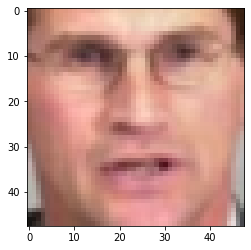

In [9]:
plt.imshow(np.moveaxis(X_train[0], 0, 2))
X_train[0].shape

Хочу ещё данных!

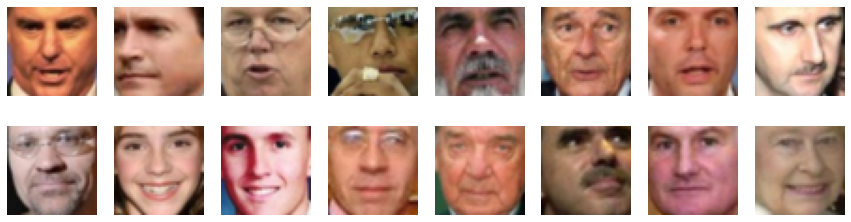

In [10]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(X_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(np.moveaxis(X_train[random_index], 0, 2))
plt.show()

С этим можно уже учить модели. 

## 2) Собираем автокодировщик для PCA 

Как мы уже выяснили, простейшим автокодировщиком является PCA. Один слой на входе, бутылочное горлышко с новыми фичами, один слой на выходе и PCA готов. 

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" alt="Autoencoder">

In [11]:
input_shape = X_train.shape[1:]
input_shape

(3, 48, 48)

In [12]:
np.prod(input_shape) # кол-во пикселей

6912

In [15]:
a = torch.tensor([[[1,2],
                   [3, 4]],
                  [[1,2],
                  [3, 4]]])

img_shape = (2,2)
torch.flatten(a, 1).reshape((2, *img_shape))

tensor([[[1, 2],
         [3, 4]],

        [[1, 2],
         [3, 4]]])

Создадим объекты `Dataloader` для подачи на вход функции обучения сети

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 256

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [17]:
class PcaAutoencoder(nn.Module):

    def __init__(self, img_shape, code_size=36):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        self.encoder = nn.Linear(np.prod(img_shape), code_size)
        self.decoder = nn.Linear(code_size, np.prod(img_shape))

    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
EPOCHS = 40

# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = PcaAutoencoder(input_shape)
autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

cuda


In [19]:
from torchsummary import summary

summary(autoencoder, (1, 3, 48, 48))

# 82980 = 48 * 48 * 36 + 36  |   weights + bias
# 85248 = 82980 + 48 * 48 + 36

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 36]         248,868
            Linear-2                 [-1, 6912]         255,744
Total params: 504,612
Trainable params: 504,612
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.05
Params size (MB): 1.92
Estimated Total Size (MB): 2.00
----------------------------------------------------------------


Обратите внимание что энкодер восстанавливает вход на выходе. У нас нет меток для обучения, а надо, чтобы ими были сами по себе исходные картинки. Немного подправим генератор данных, чтобы это правда было так. 

In [20]:
from IPython import display  # выводить график обучения в онлайн режиме
from tqdm.auto import tqdm
import os

In [21]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 25 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [22]:
model, train_loss, val_loss = train(autoencoder, 
                                    train_loader, test_loader, 
                                    device=DEVICE, epochs=200, 
                                    path='pca_autoencoder')
torch.save(model.state_dict(), 'pca_autoencoder/pca_auto_model_final.pt')

  0%|          | 0/200 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.520142;   val loss: 0.178854
After 25 epochs, training loss: 0.043724;   val loss: 0.029008
After 50 epochs, training loss: 0.032280;   val loss: 0.024787
After 75 epochs, training loss: 0.026970;   val loss: 0.022055
After 100 epochs, training loss: 0.023476;   val loss: 0.019816
After 125 epochs, training loss: 0.020889;   val loss: 0.017967
After 150 epochs, training loss: 0.018863;   val loss: 0.016395
After 175 epochs, training loss: 0.017256;   val loss: 0.015151


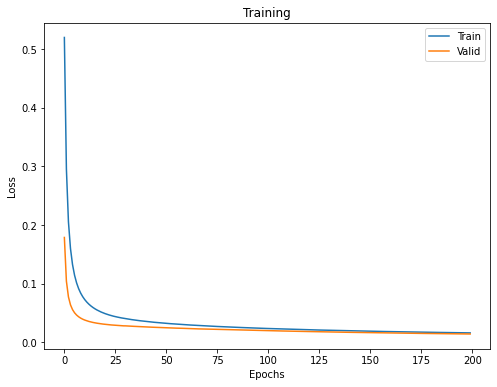

In [23]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot(train_loss, val_loss)

Наш автокодировщик обучился. это довольно приятная новость. Попробуем отрисовать оригинальные изображения, их компактные представления и то как по этим представлениям изображения восстанавливаются. 

In [24]:
# Функция для отрисовки оригинальных цифр, их представления и восстановленного рисунка
def visualize(img, model, div_coef=2):
    with torch.no_grad():
        x = torch.flatten(img)
        x = x[None, :]
        latent_code = model.encoder(x.to(DEVICE))[0].cpu()

        reco, _ = model(img[None, :, :, :].to(DEVICE))
        reco = reco[0].cpu()
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(latent_code.reshape([latent_code.shape[-1]//div_coef,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).permute(1, 2, 0))
    plt.show()

Final MSE: 0.014165368


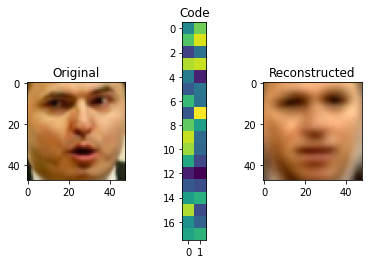

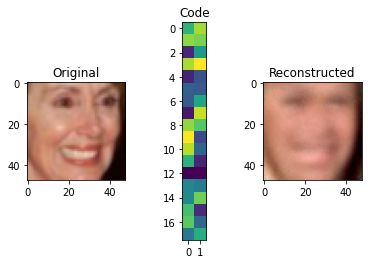

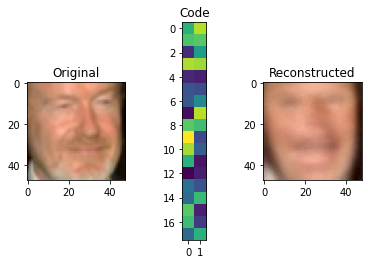

In [25]:
score = val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img, model)

Теперь по оставшимся 36 фичам (вместо оригинальных 784) можно строить классификаторы. Попробуйте на досуге заняться этим весёлым занятием, а мы движемся дальше. 

## 3) Глубокий автоэнкодер 

Всегда можно лучше! Сконструируем глубокий автокодировщик для вычленения нелинейных фичей. 

![ ](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

* Обратите внимание, что при постройке автокодировщика не должно быть слоёв меньших, чем бутылочное горлышко (выход энкодера). 
* Также обратите внимание, что вполне уместно использовать свёртки и пулинг, но такой автокодировщик будет построен чуточку ниже. 

In [26]:
class DeepAutoencoder(nn.Module):

    def __init__(self, img_shape, code_size=150):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        
        def initialization(layer):
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)
        
        self.encoder = nn.Sequential(nn.Linear(np.prod(img_shape), code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, code_size))  # Бутылочное горлышко

        self.decoder = nn.Sequential(nn.Linear(code_size, code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, np.prod(img_shape)))
        
        self.apply(initialization)
        
    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [27]:
criterion = torch.nn.MSELoss()

print('input_shape', input_shape)
deepautoencoder = DeepAutoencoder(input_shape)
deepautoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(deepautoencoder.parameters(), lr=7e-4)

input_shape (3, 48, 48)


In [28]:
deepmodel, deep_train_loss, deep_val_loss = train(deepautoencoder, 
                                                  train_loader, test_loader, 
                                                  device=DEVICE, epochs=250, 
                                                  path='deepautoencoder')
torch.save(deepmodel.state_dict(), 'deepautoencoder' + '/deep_auto_model_final.pt')

  0%|          | 0/250 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.046307;   val loss: 0.021806
After 25 epochs, training loss: 0.010155;   val loss: 0.009027
After 50 epochs, training loss: 0.007941;   val loss: 0.007389
After 75 epochs, training loss: 0.007740;   val loss: 0.007650
After 100 epochs, training loss: 0.008096;   val loss: 0.008057
After 125 epochs, training loss: 0.008211;   val loss: 0.008222
After 150 epochs, training loss: 0.008243;   val loss: 0.008303
After 175 epochs, training loss: 0.008232;   val loss: 0.008348
After 200 epochs, training loss: 0.008202;   val loss: 0.008382
After 225 epochs, training loss: 0.008160;   val loss: 0.008413


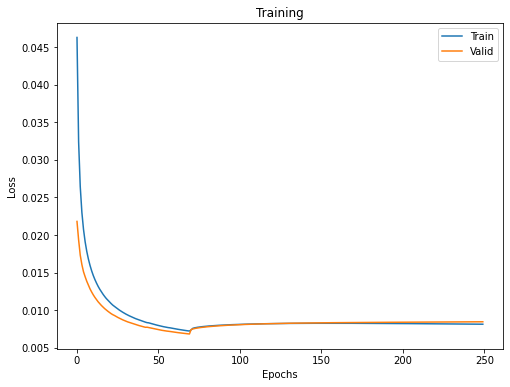

In [29]:
plot(deep_train_loss, deep_val_loss)

Final MSE: 0.008440396


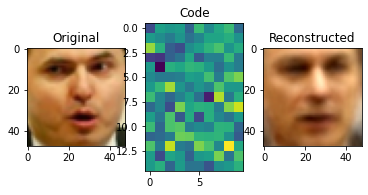

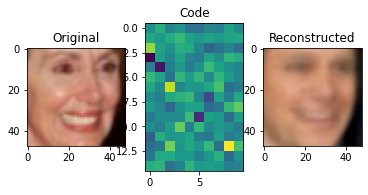

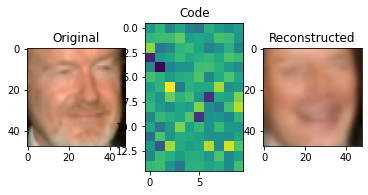

In [30]:
score = deep_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img, deepmodel, div_coef=10)

## 4) Свёрточный автокодировщик (в качестве домашнего задания*)

Добавим свёрточные слои и немного макспулинга.  Часть, которая относится к энкодеру будет стандартной. Это просто свёрточные слои и пулинг. Кончается она обычным свёрточным слоем с `code_size` нейронов. В качестве функции активации берите `elu`. 

Попробуйте повторить свёртку и пулинг $2\times2$ четыре раза с ядром размера $3 \times 3$, padding выбирете таким образом, чтобы сохранилась пространственная размероность картинки. У слоёв поставьте число каналов: $32$, $64$, $128$, $256$.


Для декодера мы будем использовать 

`torch.nn.Upsample` с scale_factor равным 2 и `torch.nn.ConvTranspose2d`. 

Проведите эксперименты с разными подходами Unpooling, сравните результаты, напишите ваши наблюдения!

In [ ]:
class CNNAutoencoder(nn.Module):
    # Ваш код здесь:

    

**Продолжение д/з:**

- Обучите модель и постройте график падения ошибки.
- Выведите привычные картинки "до/после" автоэнкодера для нескольких объектов из test выборки (*подсказка:* с помощью ранее определенной функции `visualize`)

## 5) Denoising автоэнкодер 

Автоэнкодеры можно обучить убирать шум из данных: для этого надо на вход подавать зашумленные данные и на выходе сравнивать с данными без шума. Создадим модель, которая будет зашумлять входное изображение, а после пытаться избавить его от шума. 

In [33]:
# Добавляем на картинку немного шума 
def apply_gaussian_noise(X, sigma=0.01):
  return X + sigma * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

Важно понимать, что при добавлении шума есть вероятность выйти за границы диапазона \[0, 1\], `matplotlib` предусмотрительно сам применит `np.clip` к своему входу, о чем сообщит перед рисованием картинок

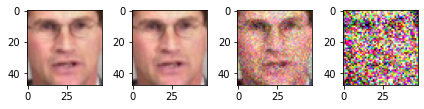

In [34]:
plt.subplot(1,4,1)
plt.imshow(X_train[0].permute(1,2,0))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.01)[0].permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.1)[0].permute(1,2,0))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.5)[0].permute(1,2,0));

plt.tight_layout()

In [35]:
# Зашумляем данные 
X_train_noisy = apply_gaussian_noise(X_train, sigma=0.1)
X_test_noisy = apply_gaussian_noise(X_test, sigma=0.1)

# Убираем все заскоки за отрезок [0;1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.).type(torch.float32)
X_test_noisy = np.clip(X_test_noisy, 0., 1.).type(torch.float32)

In [36]:
X_test_noisy.dtype

torch.float32

Нужно переопределить объект `Dataset` так, чтобы он хранил как обучаемуе выборку, так и таргет. Дело в том, что задача `Denoising автоэнкодера` научиться воссоздавать из зашумленного изображение исходное изображение  

In [37]:
dataset_train = TensorDataset(X_train_noisy, X_train)
dataset_test = TensorDataset(X_test_noisy, X_test)

BATCH_SIZE = 256

train_loader_noise = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader_noise = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

Собираем сеточку из предыдущего пункта.

In [38]:
# размер горлышка имеет смысл взять побольше (почему?)
criterion = torch.nn.MSELoss()

print('input_shape', input_shape)
denoise_autoenc = DeepAutoencoder(input_shape, code_size=1024)
denoise_autoenc.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(denoise_autoenc.parameters(), lr=1e-3)

input_shape (3, 48, 48)


In [39]:
def train_denoise(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_noizy, X in train_loader:
            batch = X_noizy.to(device)
            target = X.to(device)

            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, target)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X_noizy, X in val_loader:
                batch = X_noizy.to(device)
                target = X.to(device)

                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, target)
                
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 15 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

Ячейка ниже работает действительно долго

In [40]:
denoise_model, denoise_train_loss, denoise_val_loss = train_denoise(denoise_autoenc, 
                                                                    train_loader_noise, test_loader_noise, 
                                                                    device=DEVICE, epochs=100, 
                                                                    path='denoise_autoencoder')
torch.save(denoise_model.state_dict(), 'denoise_autoencoder' + '/denoise_auto_model_final.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.791626;   val loss: 0.026641
After 15 epochs, training loss: 0.063089;   val loss: 0.015118
After 30 epochs, training loss: 0.037382;   val loss: 0.012608
After 45 epochs, training loss: 0.028247;   val loss: 0.011561
After 60 epochs, training loss: 0.026845;   val loss: 0.013285
After 75 epochs, training loss: 0.025296;   val loss: 0.014420
After 90 epochs, training loss: 0.024241;   val loss: 0.015162


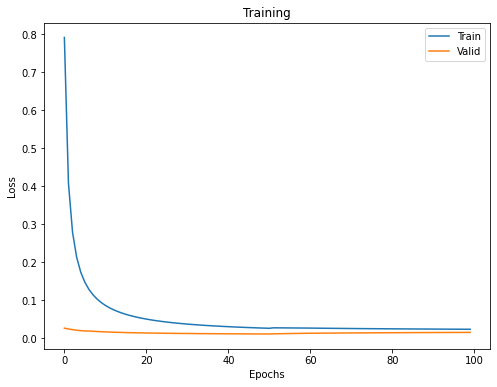

In [41]:
plot(denoise_train_loss, denoise_val_loss)

Final MSE: 0.015504068


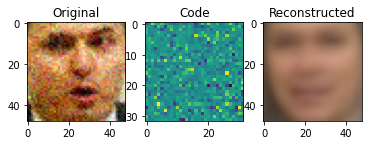

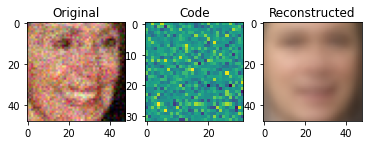

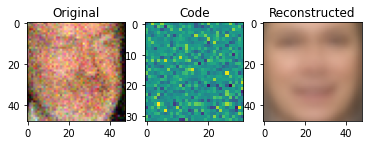

In [42]:
score = denoise_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test_noisy[i]
    visualize(img, denoise_model, div_coef=32)

## 6)  Поиск похожих изображений 

С помощью найденного горлышка можно искать похожие друг на друга изображения. Чтобы ускорить процесс поиска, мы будем использовать похожий на метод ближайших соседей, но более быстрый алгоритм под названием [Locality Sensitive Hashing forest.](http://scikit-learn.org/0.16/modules/generated/sklearn.neighbors.LSHForest.html)

In [43]:
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 256

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [44]:
def get_codes(model, loader=train_loader, device=DEVICE):
    model.eval()

    with torch.no_grad():
        codes = []
        for X in loader:
            batch = X[0].to(device)
            _, latent_code = model(batch)
            codes.append(latent_code.cpu())

    codes = torch.cat(codes)
    return codes


codes = get_codes(deepmodel, train_loader)

# хорошая идея ставить по ходу архитекрутуры проверки на размерности :) 
assert len(codes) == len(dataset_train)

In [45]:
print(codes.shape)

torch.Size([11909, 150])


In [46]:
from sklearn.neighbors import NearestNeighbors

def get_similar(image, all_images, codes, model, n_neighbors=5):
    nn = NearestNeighbors(n_neighbors=50).fit(codes)  # nn is not a Neural Network; do not mess up!

    with torch.no_grad():
        x = torch.flatten(image)
        x = x[None, :]
        latent_code = model.encoder(x.to(DEVICE)).cpu()
    (distances,), (idx,) = nn.kneighbors(latent_code, n_neighbors=n_neighbors)

    return distances, all_images[idx]

In [47]:
def show_similar(image, all_images, codes, model=deepautoencoder, n_neighbors=11):
    
    distances, neighbors = get_similar(image, all_images, codes, model, n_neighbors=n_neighbors)
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].permute(1, 2, 0))
        plt.title(f"Dist={distances[i]:.3f}")
        
    plt.tight_layout()        
    plt.show()

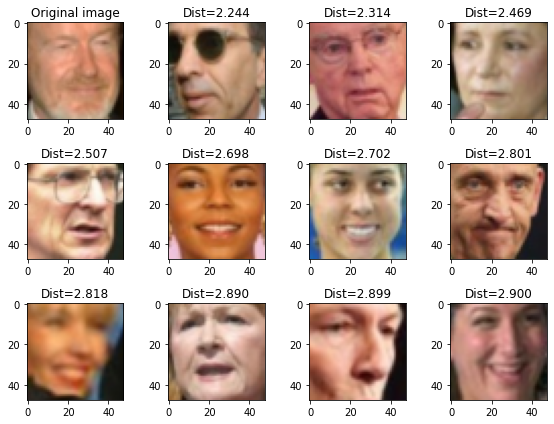

In [48]:
show_similar(X_test[2], X_train, codes, deepautoencoder)

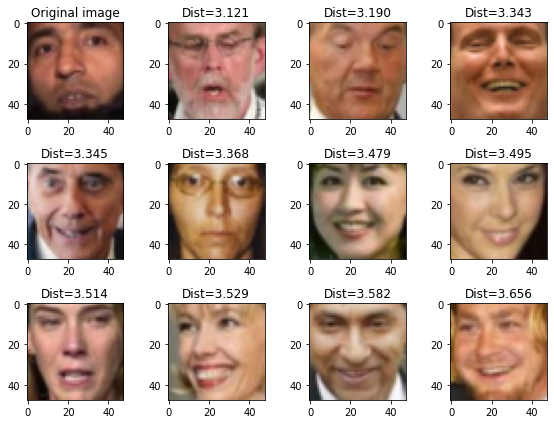

In [49]:
show_similar(X_test[500], X_train, codes, deepautoencoder)

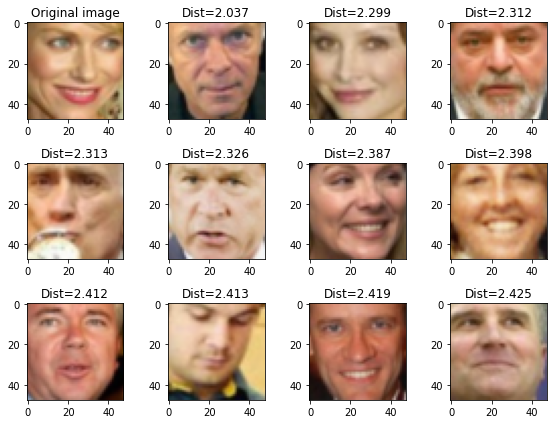

In [50]:
show_similar(X_test[66], X_train, codes, deepautoencoder)

In [51]:
X_train.shape

torch.Size([11909, 3, 48, 48])

## 7)  Прогулка по пространству эмбедингов.

Можно брать два эмбединга, искать между ними линейную комбинацию и пытаться прогуляться от одного к другому. Попробуйте вытащить для двух заданных изображений `image1` и `image2` несколько линейных комбинаций эмбедингов и посмотреть как выглядит картинка с плавным переходом от одной картинки к другой. 

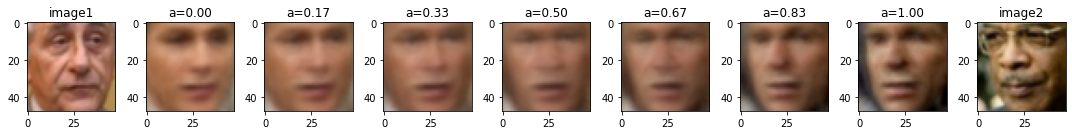

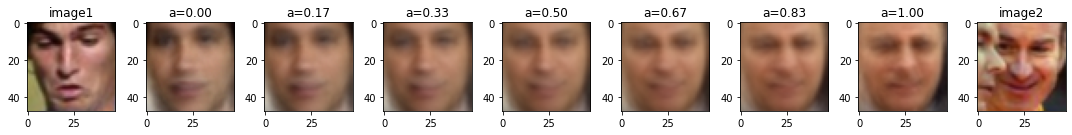

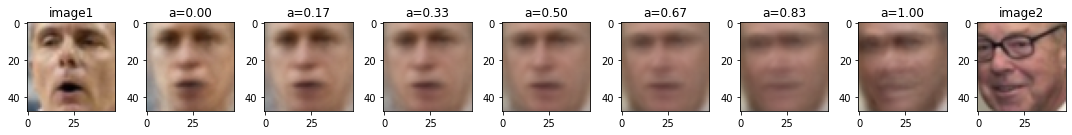

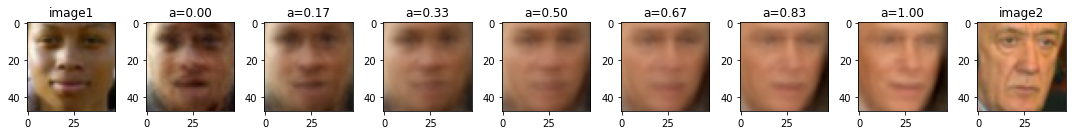

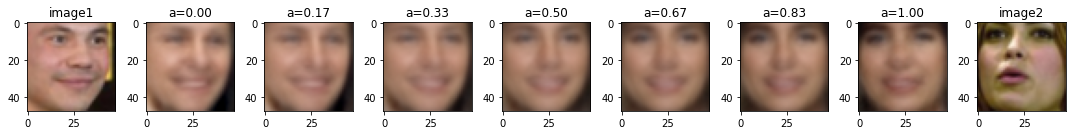

In [52]:
PATH_LEN = 7

for _ in range(5):
    image1, image2 = X_test[np.random.randint(0, len(X_test), size=2)]

    # код для поиска эмбединга
    def func_inference(image):
        with torch.no_grad():
            x = torch.flatten(image)
            x = x[None, :]
            latent_code = deepmodel.encoder(x.to(DEVICE))
            
        return latent_code
        
    code1, code2 = func_inference(image1), func_inference(image2)  # both codes are on GPU

    plt.figure(figsize=[15, 9])
    
    plt.subplot(1, PATH_LEN+2, 1)
    plt.imshow(image1.clip(0, 1).permute(1, 2, 0))
    plt.title(f"image1")  
    
    for i, a in enumerate(np.linspace(0,1,num=PATH_LEN)):

        # линейная комбинация эмбеддингов, пропущенная через слой декодера
        output_code = code1*(1-a) + code2*a
        with torch.no_grad():
            output_image = deepmodel.decoder(output_code).cpu().reshape(image1.shape)

        plt.subplot(1, PATH_LEN+2, i+1+1)
        plt.imshow(output_image.clip(0, 1).permute(1, 2, 0))
        plt.title(f"a={a:.2f}") 
        
        
    plt.subplot(1, PATH_LEN+2, PATH_LEN+2)
    plt.imshow(image2.clip(0, 1).permute(1, 2, 0))
    plt.title(f"image2")
    
    plt.tight_layout()
    plt.show()

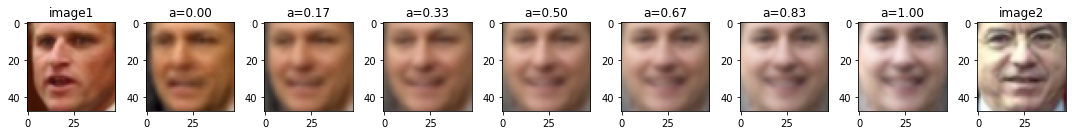

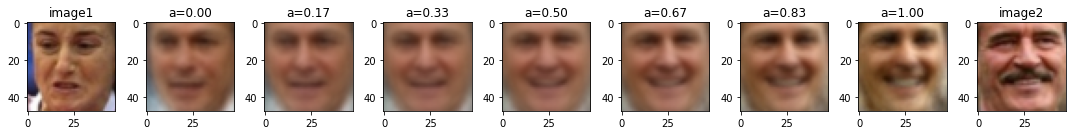

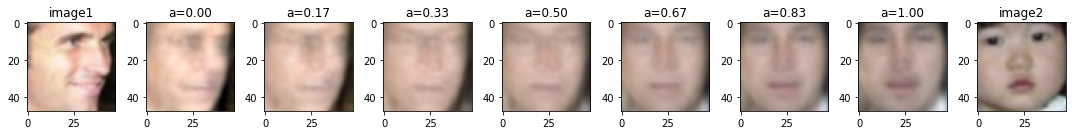

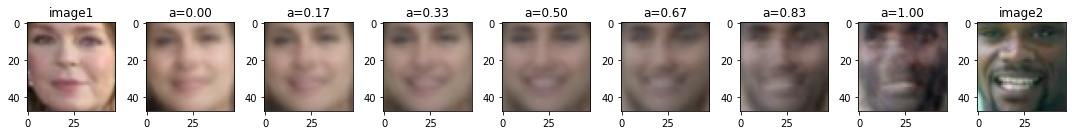

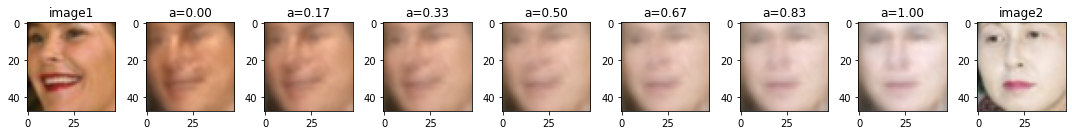

In [53]:
PATH_LEN = 7

for _ in range(5):
    image1, image2 = X_test[np.random.randint(0, len(X_test), size=2)]

    # код для поиска эмбединга
    def func_inference(image):
        with torch.no_grad():
            x = torch.flatten(image)
            x = x[None, :]
            latent_code = deepmodel.encoder(x.to(DEVICE))
            
        return latent_code
        
    code1, code2 = func_inference(image1), func_inference(image2)  # both codes are on GPU

    plt.figure(figsize=[15, 9])
    
    plt.subplot(1, PATH_LEN+2, 1)
    plt.imshow(image1.clip(0, 1).permute(1, 2, 0))
    plt.title(f"image1")  
    
    for i, a in enumerate(np.linspace(0,1,num=PATH_LEN)):

        # линейная комбинация эмбеддингов, пропущенная через слой декодера
        output_code = code1*(1-a) + code2*a
        with torch.no_grad():
            output_image = deepmodel.decoder(output_code).cpu().reshape(image1.shape)

        plt.subplot(1, PATH_LEN+2, i+1+1)
        plt.imshow(output_image.clip(0, 1).permute(1, 2, 0))
        plt.title(f"a={a:.2f}") 
        
        
    plt.subplot(1, PATH_LEN+2, PATH_LEN+2)
    plt.imshow(image2.clip(0, 1).permute(1, 2, 0))
    plt.title(f"image2")
    
    plt.tight_layout()
    plt.show()